In [ ]:
#Importing imp packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)

In [ ]:
#Reading of data and previewing it
train_file_path= 'D:/Studies/Fourth Semester/Autonomous Systems A\Truck-Platooning-Simulation-CARLA/Seminar Papers/Mohamed Amer/ML model/KDD1999 CUP data/Train_data.csv'
test_file_path = 'D:/Studies/Fourth Semester/Autonomous Systems A/ML model/Data/corrected.gz'
X = pd.read_csv(train_file_path)

print(X.iloc[:0])


In [ ]:
#Manually analysing the data
print(X.describe())


In [ ]:
always_zero_features= ['num_outbound_cmds', 'is_host_login']

In [ ]:
#check dataset distribution and null values
X.drop(always_zero_features, axis=1, inplace=True)
print(X['class'].value_counts())
print(X.isnull().sum())



In [ ]:
#removing categorical columns for first model training
y= X['class']
X.drop('class', axis=1, inplace=True)
columns_to_drop = [
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate'
]

X.drop(columns=columns_to_drop, axis=1, inplace=True)

In [ ]:

categorical_cols=X.select_dtypes(include=['object']).columns
print(categorical_cols)

In [ ]:
#Hot endcoding categorical features
encoder = OneHotEncoder(sparse=False) 
encoded_categories = encoder.fit_transform(X[['protocol_type', 'service','flag']])


encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['protocol_type', 'service','flag']))

X_copy = X.copy()

# Drop the columns and concatenate
X_copy.drop(columns=['protocol_type', 'service', 'flag'], inplace=True)
X_full = pd.concat([X_copy, encoded_df], axis=1)




In [ ]:

print(X_full.columns)





In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded= pd.DataFrame(y_encoded, index=y.index, columns=['class'])

In [ ]:
#Splitting the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_encoded, train_size=0.8, test_size=0.2,
                                                      random_state=0)





In [ ]:

rf = RandomForestClassifier(
    n_estimators=100,         
    max_depth=10,              
    min_samples_split=10,      
    min_samples_leaf=5,        
    max_features='sqrt',      
    random_state=42
)
rf.fit(X_train, y_train.values.ravel())

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns


feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})


feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

top_n = 30
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.barh(feature_importance_df['feature'][:top_n][::-1], feature_importance_df['importance'][:top_n][::-1])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



In [ ]:

#Getting Model accuracy
y_pred_pretest = rf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_pretest)
print(classification_report(y_valid, y_pred_pretest))
print(f"Model accuracy: {accuracy:.2f}")



In [ ]:
#dropping the least important features

threshold = 0.01
important_features = feature_importance_df[feature_importance_df['importance'] > threshold]['feature']
X_reduced = X_full[important_features]


#Finding correlation of Src_bytes with the target variable
import seaborn as sns
sns.boxplot(x=y, y=X['src_bytes'])


In [ ]:
X_reduced.shape

In [ ]:
# Experimenting with Variables (will be optimized later)
X_train, X_valid, y_train, y_valid = train_test_split(X_reduced, y_encoded, train_size=0.8, test_size=0.2,
                                                      random_state=0)

model_1 = RandomForestClassifier(
    n_estimators=100,        
    max_depth=10,             
    min_samples_split=10,     
    min_samples_leaf=5,       
    max_features='sqrt',   
    random_state=42
)
print(X_train.columns)
print(X_train.shape)

In [ ]:
model_1.fit(X_train, y_train.values.ravel())    
preds = model_1.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, preds))
print(classification_report(y_valid, preds))


scores = cross_val_score(model_1, X_reduced, y, cv=10)
print(f"Mean accuracy: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")
print(scores)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_valid, preds))


In [ ]:
X_with_target = pd.concat([X_train, y_train], axis=1)

# Calculate and print the correlation with the target 
correlation_matrix = X_with_target.corr()
print(correlation_matrix['class'])

In [ ]:


def plot_train_val_accuracy(y_train_true, y_train_pred, y_val_true, y_val_pred, model_name="Your Model"):
    
    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    val_accuracy = accuracy_score(y_val_true, y_val_pred)

    labels = ['Training Accuracy', 'Validation Accuracy']
    accuracies = [train_accuracy, val_accuracy]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, accuracies, color=['skyblue', 'lightcoral'])
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training vs. Validation Accuracy')
    plt.ylim(0, 1.05) # Accuracy is between 0 and 1, add a little buffer
    plt.axhline(y=train_accuracy, color='blue', linestyle='--', linewidth=0.8, label=f'Train: {train_accuracy:.4f}')
    plt.axhline(y=val_accuracy, color='red', linestyle='--', linewidth=0.8, label=f'Val: {val_accuracy:.4f}')
    plt.legend()
    plt.show()

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

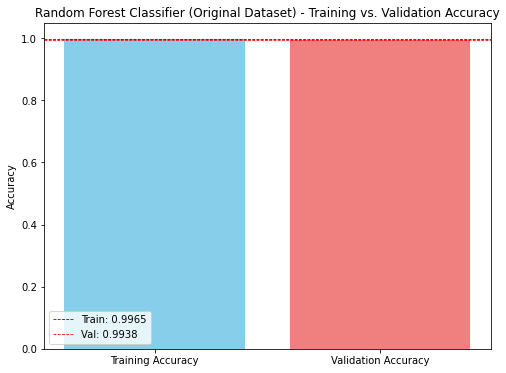

Training Accuracy: 0.9965
Validation Accuracy: 0.9938


In [24]:
y_train_preds = model_1.predict(X_train)
plot_train_val_accuracy(y_train, y_train_preds, y_valid, preds, model_name="Random Forest Classifier (Original Dataset)")